In [1]:
# http://nbviewer.jupyter.org/github/nilmtk/nilmtk/blob/v0.1.0/notebooks/fhmm.ipynb
import json
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
import itertools
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

In [2]:
pi = OrderedDict()
a = OrderedDict()
mean = OrderedDict()
cov = OrderedDict()
model = OrderedDict()
power = OrderedDict()
state =  OrderedDict()

In [3]:
pi['ref'] = np.array([0.5,0.5])
a['ref'] = np.array([[0.95,0.05],[0.05,0.95]])
mean['ref'] = np.array([[0],[120]])
cov['ref'] = np.tile(np.identity(1),(2,1,1))
model['ref'] = hmm.GaussianHMM(pi['ref'].size,"full")
model['ref'].startprob_ = pi['ref'] 
model['ref'].transmat_ = a['ref']
model['ref'].means_ = mean['ref']
model['ref'].covars_ = cov['ref']

In [5]:
model['ref'].transmat_

array([[ 0.95,  0.05],
       [ 0.05,  0.95]])

In [6]:
pi['ac']    = np.array([0.1,0.9])
a['ac']     = np.array([[0.95,0.05],[0.05,0.95]])
mean['ac']  = np.array([[0],[1500]])
cov['ac']   = np.array([[[1]],[[10]]])
model['ac'] = hmm.GaussianHMM(pi['ac'].size,"full")
model['ac'].startprob_ = pi['ac'] 
model['ac'].transmat_ = a['ac']
model['ac'].means_   = mean['ac']
model['ac'].covars_  = cov['ac']

In [7]:
pi['laptop']=np.array([0.1, 0.6, 0.3])
a['laptop']=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]])
mean['laptop']=np.array([[0],[40],[100]])
cov['laptop']=np.array([[[1.]],[[1]], [[1.]]])
model['laptop']=hmm.GaussianHMM(pi['laptop'].size, "full")
model['laptop'].startprob_ = pi['laptop'] 
model['laptop'].transmat_ = a['laptop']
model['laptop'].means_ = mean['laptop']
model['laptop'].covars_ = cov['laptop']

In [10]:
for applaince in model:
    print model[applaince].transmat_

[[ 0.95  0.05]
 [ 0.05  0.95]]
[[ 0.95  0.05]
 [ 0.05  0.95]]
[[ 0.8  0.1  0.1]
 [ 0.1  0.8  0.1]
 [ 0.1  0.1  0.8]]


In [12]:
for appliance in model:
    power[appliance],state[appliance] = model[appliance].sample(1000)


In [13]:
#model['ac'].sample(1000)

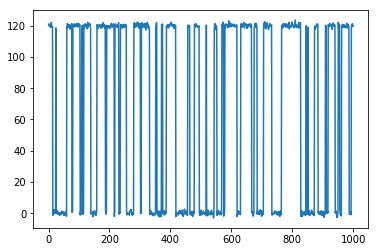

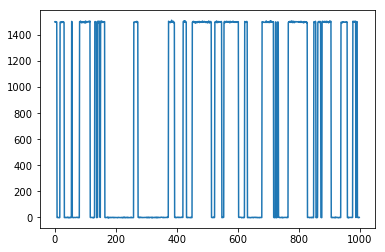

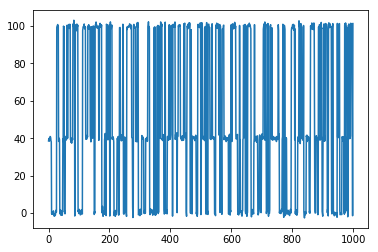

In [14]:
%matplotlib inline

for appliance in model:
    plt.figure()
    plt.plot(power[appliance])

In [15]:
power_total = np.zeros((1000,1))
for appliance in model:
    power_total+= power[appliance]

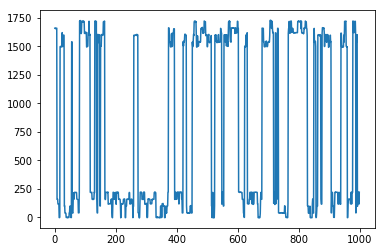

In [16]:
plt.figure()
plt.plot(power_total)

In [18]:
def compute_pi_fhmm(list_pi):
    result =  list_pi[0]
    for i in range(len(list_pi)-1):
        result = np.kron(result,list_pi[i+1])
    return result

In [19]:
list_pi = [pi[appliance] for appliance in model]
list_A = [a[appliance] for appliance in model]
list_means = [mean[appliance].flatten().tolist() for appliance in model]

In [20]:
pi_combined = compute_pi_fhmm(list_pi)

In [21]:
def compute_A_fhmm(list_A):
    '''
    Input: list_pi: List of PI's of individual learnt HMMs
    Output: Combined Pi for the FHMM
    '''
    result=list_A[0]
    for i in range(len(list_A)-1):
        result=np.kron(result,list_A[i+1])
    return result

def compute_means_fhmm(list_means):  
    '''
    Returns [mu, sigma]
    '''
    #list_of_appliances_centroids=[ [appliance[i][0] for i in range(len(appliance))] for appliance in list_B]
    states_combination=list(itertools.product(*list_means))
    print states_combination
    num_combinations=len(states_combination)
    print num_combinations
    means_stacked=np.array([sum(x) for x in states_combination])
    means=np.reshape(means_stacked,(num_combinations,1)) 
    cov=np.tile(5*np.identity(1), (num_combinations, 1, 1))
    return [means, cov]

In [22]:
A_combined = compute_A_fhmm(list_A)
[mean_combined, cov_combined]=compute_means_fhmm(list_means)

[(0, 0, 0), (0, 0, 40), (0, 0, 100), (0, 1500, 0), (0, 1500, 40), (0, 1500, 100), (120, 0, 0), (120, 0, 40), (120, 0, 100), (120, 1500, 0), (120, 1500, 40), (120, 1500, 100)]
12


In [23]:
def create_combined_hmm(n, pi, A, mean, cov):
    combined_model=hmm.GaussianHMM(n_components=n,covariance_type='full')
    combined_model.startprob_ = pi
    combined_model.transmat_ = A
    combined_model.covars_ = cov
    combined_model.means_ = mean
    return combined_model

In [24]:
model_fhmm = create_combined_hmm(len(pi_combined),pi_combined, A_combined, mean_combined, cov_combined)
learnt_states = model_fhmm.predict(power_total)
#model_fhmm.predict(power_total);

In [25]:
def decode_hmm(length_sequence, centroids, appliance_list, states):
    '''
    Decodes the HMM state sequence
    '''
    power_states_dict={}    
    hmm_states={}
    hmm_power={}
    total_num_combinations=1
    for appliance in appliance_list:
        total_num_combinations*=len(centroids[appliance])  

    for appliance in appliance_list:
        hmm_states[appliance]=np.zeros(length_sequence,dtype=np.int)
        hmm_power[appliance]=np.zeros(length_sequence)
        
    for i in range(length_sequence):
        factor=total_num_combinations
        for appliance in appliance_list:
            #assuming integer division (will cause errors in Python 3x)
            factor=factor//len(centroids[appliance])
            
            temp=int(states[i])/factor
            hmm_states[appliance][i]=temp%len(centroids[appliance])
            hmm_power[appliance][i]=centroids[appliance][hmm_states[appliance][i]]
            
    return [hmm_states,hmm_power]

In [26]:
[decoded_states, decoded_power]=decode_hmm(len(learnt_states), mean, [appliance for appliance in model], learnt_states)

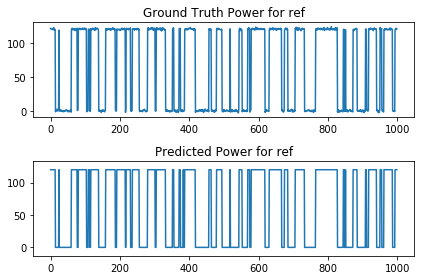

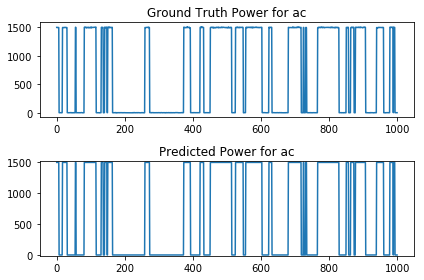

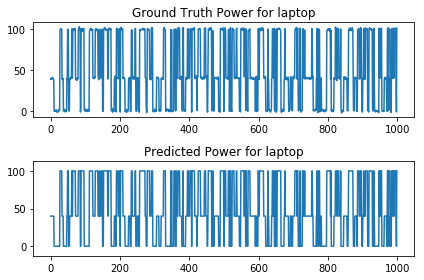

In [27]:
# don't run this: creates lot of figures
for appliance in model:
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(power[appliance])
    plt.title('Ground Truth Power for %s' %appliance)
    plt.subplot(2,1,2)
    plt.plot(decoded_power[appliance])
    plt.title('Predicted Power for %s' %appliance)
    plt.ylim((np.min(power[appliance])-10, np.max(power[appliance])+10))
    plt.tight_layout()

In [28]:
# learn modelling from data itself
learnt_model=OrderedDict()
for appliance in model:
    learnt_model[appliance]=hmm.GaussianHMM(len(mean[appliance]),"full")
    learnt_model[appliance].fit(power[appliance])
    
for appliance in learnt_model:
    print "*"*20
    print appliance
    print "*"*20
    print learnt_model[appliance].means_

********************
ref
********************
[[  1.20016719e+02]
 [ -3.05248208e-02]]
********************
ac
********************
[[  1.49992182e+03]
 [ -3.34561910e-02]]
********************
laptop
********************
[[  1.00019786e+02]
 [  3.99336086e+01]
 [ -1.67758634e-02]]


In [29]:
def return_sorting_mapping(means):
    means_copy = deepcopy(means)
    # Sorting 
    means_copy = np.sort(means_copy, axis = 0)  
    # Finding mapping
    mapping = {}
    for i, val in enumerate(means_copy):
        assert val==means[np.where(val==means)[0]]
        mapping[i] = np.where(val==means)[0][0]
    return mapping

def sort_startprob(mapping, startprob):
    """ Sort the startprob according to power means; as returned by mapping
    """
    num_elements = len(startprob)
    new_startprob = np.zeros(num_elements)
    for i in xrange(len(startprob)):
        new_startprob[i] = startprob[mapping[i]]
    return new_startprob

def sort_covars(mapping, covars):
    num_elements = len(covars)
    new_covars = np.zeros_like(covars)
    for i in xrange(len(covars)):
        new_covars[i] = covars[mapping[i]]
    return new_covars

def sort_transition_matrix(mapping, A):
    """ Sorts the transition matrix according to power means; as returned by mapping
    """
    num_elements = len(A)
    A_new = np.zeros((num_elements, num_elements))
    for i in range(num_elements):
        for j in range(num_elements):
            A_new[i,j] = A[mapping[i], mapping[j]]   
    return A_new

def sort_learnt_parameters(startprob, means, covars, transmat):
    mapping = return_sorting_mapping(means)
    means_new = np.sort(means, axis = 0)
    startprob_new = sort_startprob(mapping, startprob)
    covars_new = sort_covars(mapping, covars)
    transmat_new = sort_transition_matrix(mapping, transmat)
    assert np.shape(means_new) == np.shape(means)
    assert np.shape(startprob_new) == np.shape(startprob)
    assert np.shape(transmat_new) == np.shape(transmat)
    
    return [startprob_new, means_new, covars_new, transmat_new]

In [30]:
sort_learnt_parameters(learnt_model["ref"].startprob_, learnt_model["ref"].means_, learnt_model["ref"].covars_, learnt_model["ref"].transmat_) 

[array([ 0.,  1.]), array([[ -3.05248208e-02],
        [  1.20016719e+02]]), array([[[ 1.02266672]],
 
        [[ 0.90721874]]]), array([[ 0.92888889,  0.07111111],
        [ 0.0582878 ,  0.9417122 ]])]

In [31]:
new_learnt_models= OrderedDict()
for appliance in model:
    startprob, means, covars, transmat = sort_learnt_parameters(learnt_model[appliance].startprob_, learnt_model[appliance].means_, learnt_model[appliance].covars_ , learnt_model[appliance].transmat_) 
    #print transmat
    new_learnt_models[appliance]=hmm.GaussianHMM(startprob.size, "full")
    new_learnt_models[appliance].startprob_ = startprob
    new_learnt_models[appliance].transmat_ = transmat
    new_learnt_models[appliance].means_ = means
    new_learnt_models[appliance].covars_ = covars
    

In [33]:
for applaince in model:
    print new_learnt_models[applaince].transmat_

[[ 0.92888889  0.07111111]
 [ 0.0582878   0.9417122 ]]
[[ 0.95724907  0.04275093]
 [ 0.05206074  0.94793926]]
[[ 0.79220779  0.08766234  0.12012987]
 [ 0.09538462  0.76923077  0.13538462]
 [ 0.09016393  0.1284153   0.78142077]]


In [39]:
def create_combined_hmm(model):
    
    list_pi=[model[appliance].startprob_ for appliance in model]
    list_A=[model[appliance].transmat_ for appliance in model]
    list_means=[model[appliance].means_.flatten().tolist() for appliance in model]
    print list_pi
    pi_combined=compute_pi_fhmm(list_pi)
    A_combined=compute_A_fhmm(list_A)
    [mean_combined, cov_combined]=compute_means_fhmm(list_means)
    #model_fhmm=create_combined_hmm(len(pi_combined),pi_combined, A_combined, mean_combined, cov_combined)
    combined_model=hmm.GaussianHMM(n_components=len(pi_combined),covariance_type='full')
    combined_model.startprob_=pi_combined
    combined_model.transmat_=A_combined  
    combined_model.covars_=cov_combined
    combined_model.means_=mean_combined
    return combined_model

In [40]:
[model[appliance].transmat_prior for appliance in new_learnt_models]

[1.0, 1.0, 1.0]

In [46]:
learnt_model_combined = create_combined_hmm(new_learnt_models)
new_learnt_states=learnt_model_combined.predict(power_total)
[decoded_states, decoded_power]=decode_hmm(len(new_learnt_states), mean, [appliance for appliance in model], new_learnt_states)


[array([ 0.,  1.]), array([ 0.,  1.]), array([ 0.,  1.,  0.])]
[(-0.030524820839282363, -0.033456191021548704, -0.016775863386583493), (-0.030524820839282363, -0.033456191021548704, 39.933608556738534), (-0.030524820839282363, -0.033456191021548704, 100.0197856811762), (-0.030524820839282363, 1499.9218151379737, -0.016775863386583493), (-0.030524820839282363, 1499.9218151379737, 39.933608556738534), (-0.030524820839282363, 1499.9218151379737, 100.0197856811762), (120.01671949946338, -0.033456191021548704, -0.016775863386583493), (120.01671949946338, -0.033456191021548704, 39.933608556738534), (120.01671949946338, -0.033456191021548704, 100.0197856811762), (120.01671949946338, 1499.9218151379737, -0.016775863386583493), (120.01671949946338, 1499.9218151379737, 39.933608556738534), (120.01671949946338, 1499.9218151379737, 100.0197856811762)]
12


In [45]:
#learnt_model_combined.predict(power_total)

array([10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  6,  6,  6,  6,  0,  0,  0,
        3,  3,  3,  3,  3,  3,  3,  9,  3,  3,  5,  5,  5,  5,  2,  2,  1,
        1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  2,
        2,  0,  0,  0,  4,  4,  1,  1,  1,  7,  8,  7,  7,  8,  8,  8,  8,
        8,  8,  8,  8,  7,  7,  7,  7,  7,  1,  1,  1,  8, 11, 11, 11, 11,
       11,  9,  9, 11, 11, 11, 11, 11, 11, 11, 11, 11,  9,  9,  9,  9,  9,
        9,  9,  3,  3,  3,  3,  3,  9,  9,  9, 11,  5,  5,  5,  8,  8,  8,
        8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  8,  8, 11, 11, 11, 11, 11,
       11,  7,  7,  1,  1,  5,  4,  4,  4,  4,  5,  5,  2,  2,  3,  3,  3,
        5,  5,  5,  5,  5,  5, 11, 11, 11, 11, 11,  8,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
        1,  0,  0,  2,  8,  8,  8,  8,  7,  7,  7,  8,  8,  8,  6,  8,  8,
        8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  6,  0,  0,  6,  6,  6,
        6,  6,  6,  6,  7

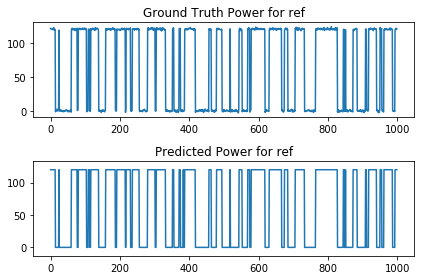

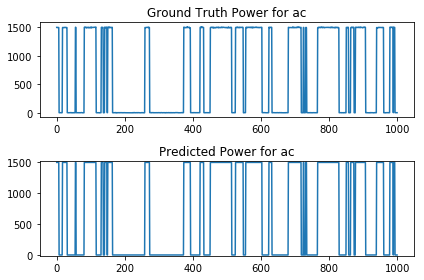

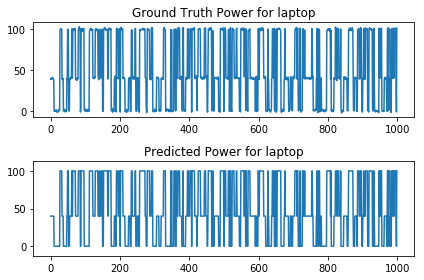

In [47]:
for appliance in model:
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(power[appliance])
    plt.title('Ground Truth Power for %s' %appliance)
    plt.subplot(2,1,2)
    plt.plot(decoded_power[appliance])
    plt.title('Predicted Power for %s' %appliance)
    plt.ylim((np.min(power[appliance])-10, np.max(power[appliance])+10))
    plt.tight_layout()

In [50]:
np.allclose(new_learnt_states, learnt_states)

True